In [1]:
import pandas as pd
import numpy as np
import os
import sklearn.preprocessing as preprocessing
import random
import torch
import torch.nn as nn
import scipy.stats as stats
from scipy.stats import gamma
import matplotlib.pyplot as plt
% matplotlib inline

# Import data

In [2]:
# preprocessing
# input_idx = [11,12,13,14,16,17,19,21,23,26,28,29,30,40,42,44,46,48,
#  50,51,54,56,58,60,61,62,63,64,65,72,74,76,78,
#  80,81,82,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,
# 100,101,102,103,104,105,106,109,110,111,112,113,114,115,117,118,119,
# 120,121,122,123,124,125,126,134,135,136,137,138,139,
# 140,143,149,150,151,152,153,154,155,156,157,158,175,
# 201,202,203,204,262,263,264,265,266,267,268,276,277,278,279,
# 280,286,287,289,290,291,292,293,294,295,296,297,298,299,
# 300,303,304,305,306,307,308,309,310,311,314,315,316,317,318,319,
# 320,327,328,332,333,338,354,360,366,372,373]

# output_idx = [24,25,27,32,33,37,47,49,52,55,59,66,67,68,69,70,71,83,
# 107,108,116,127,128,129,130,131,132,133,141,142,144,
# 207,208,209,210,212,251,272,329,330,349,350,355,356,361,362,367,368]

input_idx = pd.read_excel('x.xlsx', header=None).to_numpy().squeeze().tolist()
output_idx = pd.read_excel('y.xlsx', header=None).to_numpy().squeeze().tolist()

input_length = len(input_idx)
output_length = len(output_idx)

input_idx = [i-1 for i in input_idx]
output_idx = [i-1 for i in output_idx]
all_idx = output_idx + input_idx
output_dim = len(output_idx)

# # fist time to import data
# path = 'CSV/VC65_04_ENG'
# normal_list = []

# files = os.listdir(path)
# for file in files:
#     if file[-4:] != '.csv': continue
#     data = pd.read_csv(os.path.join(path, file),header=None, encoding = 'Shift-JIS')
#     data = data.to_numpy()
#     data = data[:, all_idx]
#     normal_list += [data]
    
# normal_np = np.array(normal_list)
# np.save('VC65_04_ENG.npy', normal_np)

In [49]:
len(input_idx)

119

# Import data (second time only)

In [3]:
# for second time to load data
normal_np = np.load('VC65_04_ENG.npy', allow_pickle=True)
# normal_np = np.where(normal_np == 'OFF', 0, normal_np)
# normal_np = np.where(normal_np == '--', 1, normal_np)
# normal_np = np.where(normal_np == 'ON', 2, normal_np)

normal_np = normal_np.astype(np.float32)

# Data structure

In [4]:
class dataset:
    def __init__(self, np):
        self.numpy = np
        self.scaled = False
        
    def scaler(self, output_length):
        self.scaled = True
        reshaped = self.numpy.reshape((-1, self.numpy.shape[-1]))
        self.scalerY = preprocessing.MaxAbsScaler().fit(reshaped[:,:output_length])
        self.scalerX = preprocessing.MaxAbsScaler().fit(reshaped[:,output_length:])
        reshaped[:, :output_length] = self.scalerY.transform(reshaped[:, :output_length])
        reshaped[:, output_length:] = self.scalerX.transform(reshaped[:, output_length:])
        self.numpy = reshaped.reshape((self.numpy.shape[0], self.numpy.shape[1], self.numpy.shape[2]))
            
    def split(self):
        length = self.numpy.shape[0]
#         fold_idx = [i for i in range(length)]
#         random.shuffle(fold_idx)
#         self.fold_idx = fold_idx
#         np.save('fold_huffle.npy', np.array(fold_idx))
        
#         self.set_idx = [i for i in range(length//3*2)]
#         random.shuffle(self.set_idx)
#         np.save('set_huffle.npy', np.array(self.set_idx))
        
        fold_idx = np.load('fold_huffle.npy')
        self.fold_idx = fold_idx.tolist()
        self.set_idx = np.load('set_huffle.npy').tolist()
        
#         fold_idx = np.load('shuffle.npy')
#         fold_idx = fold_idx.tolist()
        self.l1 = self.numpy[fold_idx[:length//3], :, :]
        self.l2 = self.numpy[fold_idx[length//3:length//3*2], :, :]
        self.l3 = self.numpy[fold_idx[length//3*2:], :, :]
        
        self.l1 = torch.from_numpy(self.l1).to(dtype=torch.float32)
        self.l2 = torch.from_numpy(self.l2).to(dtype=torch.float32)
        self.l3 = torch.from_numpy(self.l3).to(dtype=torch.float32)
#         self.l = torch.from_numpy(self.numpy).to(dtype=torch.float32)

# Data process

In [5]:
data_set = dataset(normal_np)
data_set.scaler(output_length)
data_set.split()

# Supporting functions

In [6]:
def get_set(fold, data_set):
    if fold == '1':
        dam = data_set.l1.shape[0]//3
        return torch.cat([data_set.l2, data_set.l3]), data_set.l1[dam:, :], data_set.l1[:dam, :]
    if fold == '2':
        dam = data_set.l2.shape[0]//3
        return torch.cat([data_set.l1, data_set.l3]), data_set.l2[dam:, :], data_set.l2[:dam, :]
    if fold == '3':
        dam = data_set.l3.shape[0]//3
        return torch.cat([data_set.l1, data_set.l2]), data_set.l3[dam:, :], data_set.l3[:dam, :]
    
def divide_batch(batch_num, x, y):
    x_batch_list = []
    y_batch_list = []
    interval = int(x.shape[0]/batch_num)
    print(interval)
    if batch_num == 1:
        return [x.transpose(0, 1)], [y.transpose(0, 1)]
    for i in range(batch_num - 1):
        x_batch_list += [x[interval*i:interval*(i + 1)].transpose(0, 1)]
        y_batch_list += [y[interval*i:interval*(i + 1)].transpose(0, 1)]
    x_batch_list += [x[interval*(i + 1):].transpose(0, 1)]
    y_batch_list += [y[interval*(i + 1):].transpose(0, 1)]
    return x_batch_list, y_batch_list

# Training normal data

In [39]:
## Network structure
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, batch_size=1, num_layers=2):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.output_dim = output_dim
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)
        # Define output layer
        self.linear = nn.Linear(self.hidden_dim, self.output_dim)
#         self.tanh = nn.Tanh()

#     def init_hidden(self): # Not required
#         return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).cuda(), torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).cuda())

    def forward(self, x):
        # shape of input  (seq_length, batch, input_dim)
        # shape of output (seq_length, batch, hidden_dim)
        lstm_out, _ = self.lstm(x)
        y_pred = self.linear(lstm_out)
#         y_pred = self.tanh(y_pred)
        return y_pred

fold = '3' # fold = 1, 2, 3
output_file = fold
testTraining_batch_num = 10
# os.makedirs(output_file)

training, validation, test = get_set(fold, data_set)

x_training = training[:, :, output_length:]
y_training = training[:, :, :output_length]

# x_validation = validation[:, :, output_length:]
# y_validation = validation[:, :, :output_length]

x_testTraining_batch_list, y_testTraining_batch_list = divide_batch(testTraining_batch_num, x_training, y_training)

batch_list = [i for i in range(training.shape[0])]

# Set hyperparameters
Epoch = 100000
batch_size = 100
lr = 1e-4
hidden_dim = 500
net = LSTM(input_length, hidden_dim, output_length).cuda()

# Optimizers
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
MSELoss = nn.MSELoss()
L1Loss = nn.L1Loss()
weight_flag = 0
num_train = training.shape[0]
# x_test = x_test.cuda().transpose(0, 1) # Required for LSTM network, the input dimension is [length, batch, feature]
# y_test = y_test.cuda()

# print('Start training')
# for epoch in range(Epoch): 
#     for step in range(int(num_train/batch_size)):
#         batch_content = random.sample(batch_list, batch_size)
#         x_batch = x_training[batch_content, :, :].transpose(0, 1).cuda()
#         y_batch = y_training[batch_content, :, :].transpose(0, 1).cuda()
#     #     print(torch.cuda.memory_allocated())
#         # Update process
#         y_pred = net(x_batch)
#         loss = MSELoss(y_pred, y_batch)
#         optimizer.zero_grad()
#         loss.backward(retain_graph=True)
#         optimizer.step()
    
#     testTraining_loss = 0
#     for i in range(testTraining_batch_num - 1):
#         x_testTraining_batch = x_testTraining_batch_list[i].cuda()
#         y_testTraining_batch = y_testTraining_batch_list[i].cuda()
#         testTraining_loss += MSELoss(net(x_testTraining_batch), y_testTraining_batch)
#         del x_testTraining_batch
#         del y_testTraining_batch
#         torch.cuda.empty_cache()
#     testTraining_loss = testTraining_loss/testTraining_batch_num

#     print('epoch: %d || loss: %.5f ' % (epoch, testTraining_loss.data))

#     if epoch > 10:
#         if weight_flag == 0:
#             # Save weights
#             weight_name = output_file + '/model_%d.ckpt' % (epoch)
#             torch.save(net.state_dict(), weight_name)
#             weight_flag = 1
#             best_one = testTraining_loss.data
#         else:
#             if testTraining_loss.data < best_one:
#                 weight_name = output_file + '/model_%d_%.5f.ckpt' % (epoch, testTraining_loss.data)
#                 torch.save(net.state_dict(), weight_name)
#                 best_one = testTraining_loss.data

625


# Import DTC data

In [40]:
path = 'CSV/VC65_04_ENG_dtc'
failure_dict = {}
dtc_codes = os.listdir(path)
for dtc_code in dtc_codes:
    failure_list = []
    files = os.listdir(os.path.join(path, dtc_code))
    for file in files:
       
        if file[-4:] != '.csv': continue
        data = pd.read_csv(os.path.join(path, dtc_code, file),header=None, encoding = 'Shift-JIS')
        data = data.to_numpy()
        data = data[:, all_idx]
        data = data.astype(np.float32)
        data[:, :output_length] = data_set.scalerY.transform(data[:, :output_length])
        data[:, output_length:] = data_set.scalerX.transform(data[:, output_length:])
        data = data[np.newaxis, ...]
        data = torch.from_numpy(data).to(dtype=torch.float32)
        failure_list += [data]        
    failure_dict[dtc_code] = failure_list

# Validation

In [43]:
torch.cuda.empty_cache()
net.load_state_dict(torch.load(fold + '/model_9811_0.00004.ckpt'))
x_validation = validation[:, :, output_length:]
y_validation = validation[:, :, :output_length]

x_validation = x_validation.transpose(0, 1).cuda()
y_pred = net(x_validation).transpose(0, 1).cpu().detach().numpy()
y_validation = y_validation.numpy()

# diff = (y_pred - y_validation).mean(axis=1)
val_diff = abs(y_pred - y_validation)
# val_diff = y_pred - y_validation
# delete large mse
# val_diff = np.mean(val_diff, axis=1)
mean = np.mean(val_diff, axis=1)
std = np.std(val_diff, axis=1)
val = np.concatenate([mean, std], axis=1)
# val = mean
# thresh = np.abs(mean) + 3*abs(std)

# 4 sigma: 0.999936657516334
# 1 - 1/2084 = 0.9995201535508638

In [44]:
# Test result
test_result_dtc = []
for dtc_code in failure_dict:
#     dtc_code = list(failure_dict.keys())[0]

    for test_dtc in failure_dict[dtc_code]:
#         test_dtc = failure_dict[dtc_code][0]

        x_test_dtc = test_dtc[:, :, output_length:]
        y_test_dtc = test_dtc[:, :, :output_length]
        x_test_dtc = x_test_dtc.transpose(0, 1).cuda()
        y_pred = net(x_test_dtc).transpose(0, 1).cpu().detach().numpy()
        y_test_dtc = y_test_dtc.numpy()

#         diff = y_pred - y_test_dtc
        diff = abs(y_pred - y_test_dtc)
#         diff = diff.mean(axis=1)[0]
        mean = np.mean(diff, axis=1)
#         mean = np.expand_dims(mean, axis=1)
        std = np.std(diff, axis=1)
        sample = np.concatenate([mean, std], axis=1)[0]
#         test_result_dtc += [mean[0]]
        test_result_dtc += [sample]
        
#         print(judge)


test_result_dtc = np.array(test_result_dtc)
# failure_np = reshaped.reshape((failure_np.shape[0], failure_np.shape[1], failure_np.shape[2]))
# failure_dict[dtc_code] = failure_np
# np.save('dtc.npy', test_result_dtc)

In [45]:
x_test = test[:, :, output_length:]
y_test = test[:, :, :output_length]

x_test = x_test.transpose(0, 1).cuda()
y_pred = net(x_test).transpose(0, 1).cpu().detach().numpy()
y_test = y_test.numpy()
# diff = y_pred - y_test
diff = abs(y_pred - y_test)
# test_result = diff.mean(axis=1)
# test_result = np.mean(diff, axis=1)
mean = np.mean(diff, axis=1)
std = np.std(diff, axis=1)
test_result = np.concatenate([mean, std], axis=1)
# test_result = mean

In [990]:
val.shape

(2084, 160)

In [46]:
from sklearn import mixture
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn import decomposition

pca = decomposition.PCA(n_components=60)
pca.fit(val)
test_result0 = pca.transform(test_result)
val0 = pca.transform(val)
test_result_dtc0 = pca.transform(test_result_dtc)

# g = EllipticEnvelope(contamination=0.01, random_state=0)
# g = OneClassSVM(gamma='auto', degree=5, kernel='rbf',nu=0.1)
# g = mixture.GaussianMixture(n_components=1, covariance_type='full', max_iter=100000)
g = IsolationForest(contamination=0.015, n_estimators=5000, behaviour='new', max_samples=2000)
g.fit(val0) 
print(np.sum(np.sum((g.predict(val0)>0)*1)/val0.shape[0]))
print(np.sum(np.sum((g.predict(test_result0)>0)*1)/test_result0.shape[0]))
print(np.sum(np.sum((g.predict(test_result_dtc0)<0)*1)/test_result_dtc0.shape[0]))

0.9846596356663471
0.9788867562380038
0.9615384615384616


In [48]:
test_result0.shape[0]
np.sum((g.predict(test_result_dtc0)<0)*1)
np.sum((g.predict(test_result0)>0)*1)
np.sum((g.predict(val0)>0)*1)

2054

In [925]:
std = np.std(val_diff, axis=0)
mean = np.mean(val_diff, axis=0)

a = np.where(std/mean > 100)[0]
print(a)

[  0   0   0 ... 159 159 159]


In [815]:
b = np.where(std > 0.1)[0]
print(b)

[42 68 97]


In [843]:
c = np.where(abs(mean) > 0.00004)[0]
print(c)

[  0   1   2   3   4   5   7   8   9  11  12  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  28  29  30  31  37  38  39  42  43  44  45
  46  47  48  49  50  52  54  55  56  57  58  59  60  61  62  64  65  67
  68  69  70  72  73  75  76  88  89  90  91  92  93  94  96  97  98 100
 101 102 103 104 105 106 108 109 110 111 113 114 115 116 117 118 119 120
 122 123 124 125 126 127 128 129 130 131 133 134 135 136 139 140 141 142
 143 144]


In [831]:
c = np.where(mean > 0.00001)[0]
print(c)

[  0   6   7  13  14  16  20  50  58  92 105 115]


In [735]:
d = np.where(mean/std > 0.1)[0]
print(d)

[  2  14  15  16  20  30  36  37  39  42  44  46  47  48  50  52  53  54
  55  56  59  69  76  77  89  90  92  93  94  96 100 101 102 103 104 105
 108 109 116 117 118 119 122 123 124 125 126 128 135 136 139 140 141 144]


In [846]:
drop_list = np.unique(np.concatenate((b, c), axis=0))
val_diff = np.delete(val_diff, drop_list, axis=1)

In [844]:
len(c)

110

In [737]:
drop_list.shape

(110,)

In [775]:
print(np.sum(np.sum((g.predict(val_diff)>0)*1)/val_diff.shape[0]))
print(np.sum(np.sum((g.predict(test_result)>0)*1)/test_result.shape[0]))
print(np.sum(np.sum((g.predict(test_result_dtc)<0)*1)/test_result_dtc.shape[0]))

0.9899232245681382
0.9817658349328215
0.5384615384615384


In [817]:
np.sum(np.sum((g.predict(test_result_dtc)<0)*1)/test_result_dtc.shape[0])

0.8461538461538461

In [604]:
np.sum(np.sum((g.predict(test_result)>0)*1)/test_result.shape[0])

0.9481765834932822

In [860]:
test_result_dtc.shape

(52, 60)

In [850]:
test_result_dtc = np.delete(test_result_dtc, drop_list, axis=1)

In [851]:
test_result = np.delete(test_result, drop_list, axis=1)

In [48]:
a = g.predict(sample)
np.savetxt("rn.csv", a, delimiter=",")

In [406]:
test_result.shape

(1042, 160)

In [ ]:
dd = np.sum(test_result_dtc[:, judge4].squeeze(), axis=1)
np.savetxt("r_dtc.csv", dd, delimiter=",")

In [ ]:
nn = np.sum(test_result[:, judge4].squeeze(), axis=1)
np.savetxt("r_normal.csv", nn, delimiter=",")

In [95]:
test_result

array([38.178093, 86.45348 , 53.3025  , ..., 78.117966, 34.780685,
       35.026764], dtype=float32)

In [96]:
np.savetxt("r.csv", r , delimiter=",")

In [55]:
judge = (abs(mse) > abs(thresh)) * 1
'''
judge.shape[0]*0.10 = 208.4
'''
judge1 = np.sum(judge, axis=1)
# re = np.sum(judge, axis=0)
np.savetxt("foo1.csv", judge1, delimiter=",")

In [56]:
judge2 = judge[np.where(judge1 < 3)]

In [57]:
judge3 = np.sum(judge2, axis=0)
judge3

array([ 2,  1,  3,  2,  0,  0,  0,  3,  8,  3,  1, 11, 10,  1,  0,  0,  0,
        3,  7,  6,  8,  0,  1,  0,  0,  8,  8,  1,  4,  0,  0,  4,  0,  0,
        0,  0,  0,  0,  8,  0,  0,  0,  0,  2,  0,  4,  0,  0,  0,  3,  1,
        0,  0,  0,  0,  0,  0,  0,  3,  0,  2,  0,  2,  0,  1,  4,  1, 12,
       10,  0, 10, 10,  2,  2, 11,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  2,  0,  0, 29,  0,  0,  0,  0,  0, 22, 40,  0,  0,  0,
        0,  0,  0,  0,  6,  9,  0,  0,  3, 13,  2,  1,  2,  6,  0,  0,  0,
        6, 10,  0,  0,  0,  0,  0,  0,  2,  5, 11,  2,  1,  7,  5,  2,  0,
        0,  4,  1,  0,  1,  0,  2,  5,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0])

In [58]:
judge4 = np.where(judge3 < 1)

In [59]:
# Test result
test_result_dtc = []
for dtc_code in failure_dict:
#     dtc_code = list(failure_dict.keys())[0]

    for test_dtc in failure_dict[dtc_code]:
#         test_dtc = failure_dict[dtc_code][0]

        x_test_dtc = test_dtc[:, :, output_length:]
        y_test_dtc = test_dtc[:, :, :output_length]
        x_test_dtc = x_test_dtc.transpose(0, 1).cuda()
        y_pred = net(x_test_dtc).transpose(0, 1).cpu().detach().numpy()
        y_test_dtc = y_test_dtc.numpy()

        mse = (y_pred - y_test_dtc).mean(axis=1)
        judge = (abs(mse) > abs(thresh)) * 1
        test_result_dtc += [judge.squeeze()]
#         print(judge)


test_result_dtc = np.array(test_result_dtc)
# failure_np = reshaped.reshape((failure_np.shape[0], failure_np.shape[1], failure_np.shape[2]))
# failure_dict[dtc_code] = failure_np
np.save('dtc.npy', test_result_dtc)

In [63]:
x_test = test[:, :, output_length:]
y_test = test[:, :, :output_length]

x_test = x_test.transpose(0, 1).cuda()
y_pred = net(x_test).transpose(0, 1).cpu().detach().numpy()
y_test = y_test.numpy()
mse = (y_pred - y_test).mean(axis=1)
test_result = (abs(mse) > abs(thresh)) * 1

In [50]:
x_test.shape

torch.Size([160, 1042, 119])

In [64]:
dd = np.sum(test_result_dtc[:, judge4].squeeze(), axis=1)
np.savetxt("r_dtc.csv", dd, delimiter=",")

In [65]:
nn = np.sum(test_result[:, judge4].squeeze(), axis=1)
np.savetxt("r_normal.csv", nn, delimiter=",")

In [386]:
judge4[0].shape

(110,)

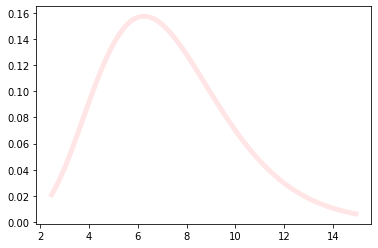

In [54]:

fig, ax = plt.subplots(1, 1)
a, loc, b = gamma.fit(mse[:,0],)
# gamma.pdf(x, a, loc, scale) 
x = np.linspace(gamma.ppf(0.01, a),

                gamma.ppf(0.99, a), 100)

ax.plot(x, gamma.pdf(x, a),'r-', lw=5, alpha=0.1, label='gamma pdf')

{'boxes': [<matplotlib.lines.Line2D at 0x7fd30da55550>],
 'caps': [<matplotlib.lines.Line2D at 0x7fd30da55da0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fd30d8cf7b8>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fd30d8cf470>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fd30da556a0>,
  <matplotlib.lines.Line2D at 0x7fd30da55a58>]}

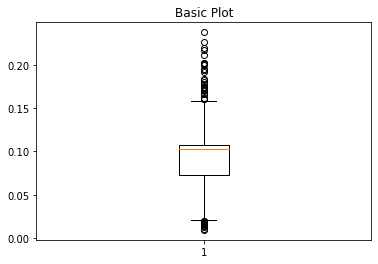

In [53]:
% matplotlib inline
fig1, ax1 = plt.subplots()
ax1.set_title('Basic Plot')
ax1.boxplot(mse[:,0])

In [27]:
judge.shape
# np.mean(judge, axis=0)
# np.sum(judge, axis=0)

(2086, 160)

In [67]:
# judge = (mse > thresh) * 1
a = np.sum(judge, axis=1)
a = np.sum(a, axis=0)
print(judge)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [56]:
a = np.array([1,2])
a**0.5

array([1.        , 1.41421356])

In [44]:
judge.shape
np.savetxt("foo.csv", judge, delimiter=",")

In [80]:
# Test result
test_result_dtc = []
for dtc_code in failure_dict:
#     dtc_code = list(failure_dict.keys())[0]

    for test_dtc in failure_dict[dtc_code]:
#         test_dtc = failure_dict[dtc_code][0]

        x_test_dtc = test_dtc[:, :, output_length:]
        y_test_dtc = test_dtc[:, :, :output_length]
        x_test_dtc = x_test_dtc.transpose(0, 1).cuda()
        y_pred = net(x_test_dtc).transpose(0, 1).cpu().detach().numpy()
        y_test_dtc = y_test_dtc.numpy()

        mse = ((y_pred - y_test_dtc)**2).mean(axis=1)
        judge = (mse > thresh) * 1
        test_result_dtc += [judge.squeeze()]
#         print(judge)


test_result_dtc = np.array(test_result_dtc)
# failure_np = reshaped.reshape((failure_np.shape[0], failure_np.shape[1], failure_np.shape[2]))
# failure_dict[dtc_code] = failure_np
np.save('dtc.npy', test_result_dtc)

In [81]:
x_test = test[:, :, output_length:]
y_test = test[:, :, :output_length]

x_test = x_test.transpose(0, 1).cuda()
y_pred = net(x_test).transpose(0, 1).cpu().detach().numpy()
y_test = y_test.numpy()
mse = ((y_pred - y_test)**2).mean(axis=1)
test_result = (mse > thresh) * 1

In [82]:
np.sum(test_result_dtc, axis=0)

array([ 0,  8,  5,  4,  0,  0,  4, 24,  0, 23,  0,  1,  1,  9,  4,  4,  4,
        0, 15, 14,  0,  0,  5,  0,  0,  0,  0,  0,  0,  0,  4,  0,  0,  0,
        0,  0,  4,  4,  0,  4,  0,  0,  0,  0,  4,  0,  4,  4,  4,  1,  3,
        0,  4,  4,  4,  4,  0,  0,  0,  0,  0,  4,  4,  4,  3,  0,  0,  0,
        0,  4,  1,  0,  0,  0,  0,  0,  4,  4,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  4,  4,  0,  4,  4,  4,  4,  4,  9,  0,  0,  4,  4,
        4,  4,  4,  4,  0,  4,  4,  4,  0,  0,  7,  0,  0,  2,  4,  4,  4,
        4,  0,  4,  4,  4,  4,  4,  4,  0,  0,  0,  0,  0,  0,  0,  1,  0,
        4,  0,  0,  4,  4,  0,  4,  0,  4,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0])

In [83]:
np.sum(test_result, axis=0)

array([ 0,  0,  0,  0,  0,  0,  0,  0,  4,  2,  0,  0,  0,  0,  1,  1,  1,
        0,  1,  1,  0,  0,  1,  1,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,
        0,  0,  1,  1,  0,  1,  0,  0,  0,  0,  1,  0,  1,  1,  1,  0,  0,
        0,  1,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,
        0,  1,  1,  5,  0,  0,  0,  0,  1,  1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  1,  1,  2,  1,  1,  1,  0,  1, 19,  0,  0,  0,  1,
        1,  1,  1,  1,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  1,  1,  1,
        0,  0,  0,  0,  1,  1,  1,  1,  0,  0,  0,  0,  0,  0,  0,  2,  0,
        0,  0,  0,  0,  0,  0,  0,  2,  1,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0])

In [94]:
np.savetxt("normal.csv", test_result.sum(axis=1), delimiter=",")

In [93]:
# np.save('dtc.npy', test_result_dtc.sum(axis=1))
np.savetxt("dtc.csv", test_result_dtc.sum(axis=1), delimiter=",")

In [33]:
np.savetxt("foo.csv", a, delimiter=",")

In [20]:
path = 'CSV/VC65_04_ENG_dtc'
failure_dict = {}

dtc_codes = os.listdir(path)
for dtc_code in dtc_codes:
    failure_list = []
    files = os.listdir(os.path.join(path, dtc_code))

    for file in files:
        if file[-4:] != '.csv': continue
        data = pd.read_csv(os.path.join(path, dtc_code, file),header=None, encoding = 'Shift-JIS')
        data = data.to_numpy()
        data = data[:, all_idx]
        data = data.astype(np.float32)

        data[:, :output_length] = data_set.scalerY.transform(data[:, :output_length])
        data[:, output_length:] = data_set.scalerX.transform(data[:, output_length:])
        data = data[np.newaxis, ...]
        data = torch.from_numpy(data).to(dtype=torch.float32)
        failure_list += [data]
        
    failure_dict[dtc_code] = failure_list


# failure_np = reshaped.reshape((failure_np.shape[0], failure_np.shape[1], failure_np.shape[2]))
# failure_dict[dtc_code] = failure_np
# np.save('VC65_04_ENG_dtc.npy', normal_np)